 # QDL 튜토리얼



 이 노트북은 KAIST `고급금융계량분석` 과제(FF5 + Momentum + STR 팩터 복제)를 위한 사용 예시를 제공합니다. 과제 요구사항은 `docs/assignment_ff5.md` 를 참고하십시오. 여기서는 공개 메서드만 사용하며, 내부 구현 세부는 다루지 않습니다.





In [1]:
# 시작하기: 퍼사드 임포트
from qdl.facade import QDL
import numpy as np



 ## 1. 데이터 로드

 ### 1.1 팩터 데이터

In [2]:
# 1) 데이터 로드 (와이드)
q = QDL()

# 팩터 데이터셋 (와이드, 과제 백틱 변수 사용, mkt 제외)
selected_factors = [
    "market_equity",  # Size
    "be_me",          # Value
    "ope_be",         # Profitability
    "at_gr1",         # Investment
    "ret_12_1",       # Momentum
    "ret_1_0",        # Short-term reversal
]
wide2 = q.load_factors(
    country="usa",
    dataset="factor",
    weighting="vw",
    factors=selected_factors,
    strict=False,
)
print("팩터(와이드) 상위 5행:\n", wide2.head(5))



팩터(와이드) 상위 5행:
             market_equity  be_me  ope_be  at_gr1  ret_12_1   ret_1_0
date                                                                
1926-01-31       0.029126    NaN     NaN     NaN       NaN       NaN
1926-02-28      -0.037440    NaN     NaN     NaN       NaN -0.032849
1926-03-31      -0.055915    NaN     NaN     NaN       NaN -0.064302
1926-04-30       0.004941    NaN     NaN     NaN       NaN -0.007491
1926-05-31      -0.007117    NaN     NaN     NaN       NaN -0.011291


 ### 1.2 특성 데이터

In [3]:
# 특성(Chars) 데이터셋 (와이드): 단일 특성 예시 'me'
wide_char_me = q.load_char(
    country="usa",
    vintage="2020-",
    char="me",
)
print("특성 'me'(와이드) 상위 5행:\n", wide_char_me.head(5))



특성 'me'(와이드) 상위 5행:
             10026.0      10028.0      10032.0      10044.0      10051.0      \
eom                                                                           
2020-01-31  3137.526891    58.425082  2078.268720    49.919998   912.167351   
2020-02-29  3042.553719    71.617842  1947.704205    46.457899   861.387649   
2020-03-31  2285.448000    67.848479  1601.608840    29.112001   583.143817   
2020-04-30  2399.342617    98.272603  1829.670300    27.595751   693.677543   
2020-05-31  2429.563532    96.657158  1874.324956    26.001690   693.879503   

            10066.0        10104.0       10107.0       10138.0      \
eom                                                                  
2020-01-31          NaN  168241.192497  1.294777e+06  31408.125133   
2020-02-29          NaN  158650.316603  1.232256e+06  27855.198914   
2020-03-31          NaN  152412.720494  1.197019e+06  22262.735598   
2020-04-30          NaN  167045.348330  1.359028e+06  26311.490245   
2020-

 ## 2. 팩터 검증

In [4]:
# 2) 검증 준비: 노이즈 추가 및 교집합 정렬
rng = np.random.default_rng(42)
noise = rng.normal(loc=0.0, scale=0.02, size=wide2.shape)
noise = np.clip(noise, -0.1, 0.1)
noisy_wide2 = wide2.add(noise, fill_value=0.0)

user_wide = noisy_wide2.iloc[12:].copy()
ref_wide = wide2.iloc[:-6].copy()

common_idx = user_wide.index.intersection(ref_wide.index)
common_cols = user_wide.columns.intersection(ref_wide.columns)
user_aligned = user_wide.loc[common_idx, common_cols]
ref_aligned = ref_wide.loc[common_idx, common_cols]

print("검증 기간:", common_idx.min(), "~", common_idx.max())
print("정렬된 길이:", len(common_idx))
print("열 집합 동일 여부:", set(user_aligned.columns) == set(ref_aligned.columns))



검증 기간: 1927-01-31 00:00:00 ~ 2024-06-30 00:00:00
정렬된 길이: 1170
열 집합 동일 여부: True



검증 리포트:
관측치수: 6150 시작일: 1927-01-31 00:00:00 종료일: 2024-06-30 00:00:00
mse: 4.055 rmse: 2.014 mae: 1.597 corr: 0.885

팩터별 지표:
market_equity: 관측치수=1170, mse=3.699, rmse=1.923, mae=1.528, corr=0.913, ic=0.848
ret_12_1: 관측치수=1170, mse=3.957, rmse=1.989, mae=1.572, corr=0.922, ic=0.845
ret_1_0: 관측치수=1170, mse=4.182, rmse=2.045, mae=1.625, corr=0.877, ic=0.772
be_me: 관측치수=884, mse=4.437, rmse=2.106, mae=1.676, corr=0.845, ic=0.789
ope_be: 관측치수=884, mse=4.183, rmse=2.045, mae=1.624, corr=0.830, ic=0.751
at_gr1: 관측치수=872, mse=3.974, rmse=1.994, mae=1.581, corr=0.836, ic=0.772


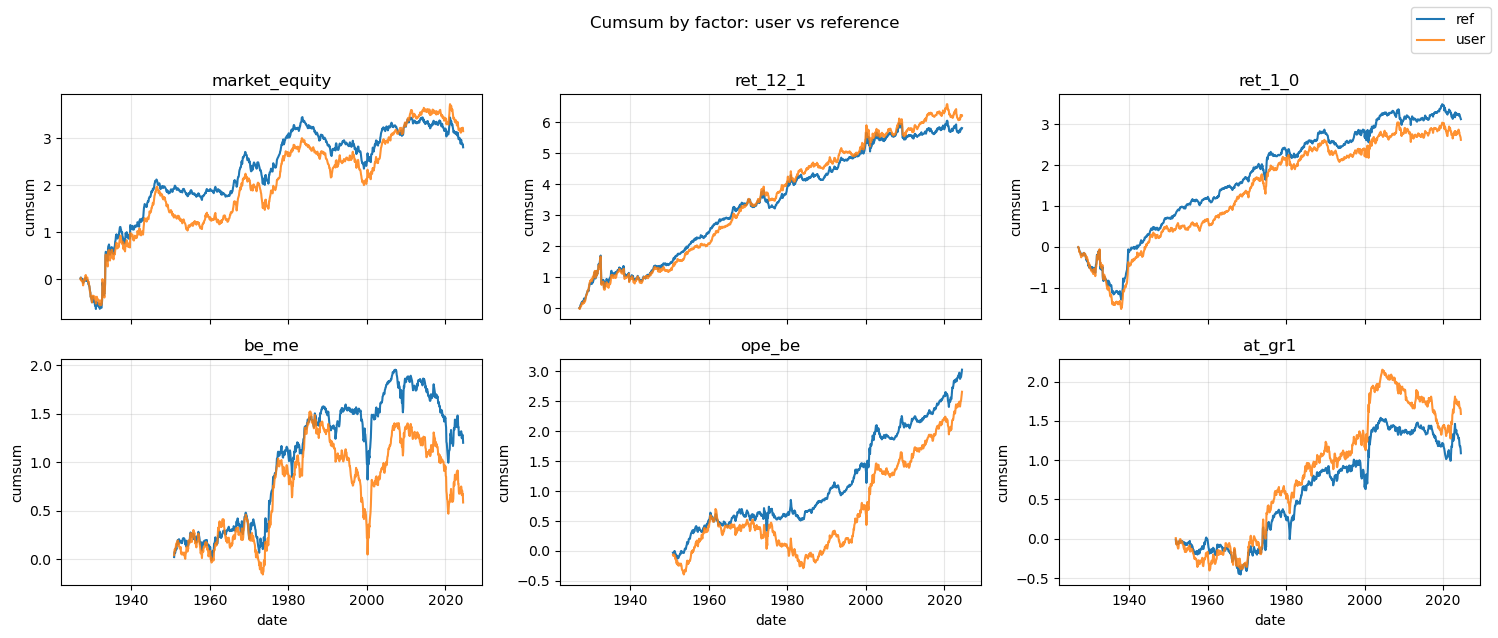

In [5]:
# 3) 팩터 검증(와이드, 퍼사드의 간편 인터페이스 사용; 팩터별 cumsum 플롯 포함)
report = q.validate_factor(
    user=user_aligned,
    weighting="vw",
    return_plot=True,
    plot_title="Cumsum by factor: user vs reference",
    max_plot_factors=12,
)
print("\n검증 리포트:")
print("관측치수:", report.n_obs, "시작일:", report.date_start, "종료일:", report.date_end)

def _fmt(x):
    return f"{x:.3f}" if x is not None else "nan"

print(
    "mse:", _fmt(report.mse),
    "rmse:", _fmt(report.rmse),
    "mae:", _fmt(report.mae),
    "corr:", _fmt(report.corr),
)

if report.per_factor_metrics:
    print("\n팩터별 지표:")
    for factor, metrics in report.per_factor_metrics.items():
        n = (report.per_factor_n_obs or {}).get(factor)
        print(
            f"{factor}: 관측치수={n}, mse={_fmt(metrics.get('mse'))}, rmse={_fmt(metrics.get('rmse'))}, "
            f"mae={_fmt(metrics.get('mae'))}, corr={_fmt(metrics.get('corr'))}, ic={_fmt(metrics.get('ic'))}"
        )

try:
    import matplotlib.pyplot as plt
    if report.figure is not None:
        plt.show(report.figure)
except Exception:
    pass



